## 1) Data Analysis

In [39]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nShapes:")
for key, tensor in sample.items():
    print(f"{key}: {tensor.shape}")

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Shapes:
sdf: torch.Size([48, 48, 48])
grasps: torch.Size([480, 7])
scores: torch.Size([480])

Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



## 2) Overfitting on 1 sample

In [40]:
from pathlib import Path
from dataset import GraspDataset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

### 2.1) Initialize the model

In [41]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977


### 2.2) Get a small number of samples

In [42]:
# Create dataset
data_path = Path('data/processed')

dataset = GraspDataset(data_path)

scene = dataset[0]

def get_samples(scene, num_samples):
    # Get num_samples many unique indices
    indices = torch.randperm(len(scene['grasps']))[:num_samples]
    samples = []
    for i in indices:
        sample = {
            'grasps': scene['grasps'][i].float().to(device),
            'scores': scene['scores'][i].float().to(device),
            'sdf': scene['sdf'].float().to(device)
        }
        samples.append(sample)
    return samples

samples = get_samples(scene, 10)

for i, sample in enumerate(samples[:3]):
    print(f"Sample {i}:")
    print("\tgrasps: ", sample['grasps'].tolist())
    print("\tscore: ", sample['scores'].item())


print(samples[0]['grasps'].shape)
print(samples[0]['scores'].shape)
print(samples[0]['sdf'].shape)



Sample 0:
	grasps:  [0.5054746270179749, -0.30245712399482727, 0.22093413770198822, 0.4473852515220642, -0.1698407381772995, 0.22093413770198822, 0.020331908017396927]
	score:  0.2908475995063782
Sample 1:
	grasps:  [-0.15527531504631042, 0.051241133362054825, 0.5109341740608215, -0.00543984305113554, -0.24455110728740692, 0.29093414545059204, -0.05535813421010971]
	score:  4.798680782318115
Sample 2:
	grasps:  [1.8254671096801758, -0.11798396706581116, -0.3390658497810364, 0.4247075319290161, -0.185663640499115, 1.50093412399292, 1.8254671096801758]
	score:  -0.23100000619888306
torch.Size([7])
torch.Size([])
torch.Size([48, 48, 48])


### 2.3) Overfit on these samples from that one scene

[3.3578329416923225, 3.351738533517346, 3.3467839552788066, 3.3420935980044306, 3.3373827493051067, 3.3325183332664894, 3.3271476332098247, 3.321318374108523, 3.3152254891232587, 3.3080593465361745, 3.299414125122712, 3.289671158909914, 3.279697585789063, 3.2681596997152154, 3.2527044883026974, 3.237491379841231, 3.2227034751558676, 3.206209039373789, 3.1889416184436414, 3.171093037335595, 3.1522676274122206, 3.1344539019279183, 3.1157703625503927, 3.0985187691636384, 3.0805440861731768, 3.0646216712892054, 3.0489865211769938, 3.03604226289317, 3.0244412493892012, 3.014778626244515, 3.006335802259855, 2.999667256657267, 2.994259400340161, 2.9901393842155812, 2.986986438720487, 2.984294801973738, 2.982209864608012, 2.980564542207867, 2.9790279731620104, 2.9777960604522375, 2.97696794513613, 2.9762587712612003, 2.9757680517621337, 2.9755003358237446, 2.974622671492398, 2.9746320794336496, 2.9738847501575947, 2.973855051957071, 2.973603675886989, 2.973373271431774, 2.9728855889290573, 2.9

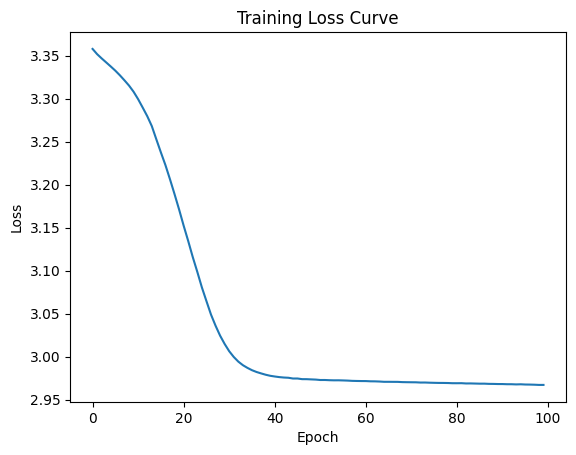

In [43]:
EPOCHS = 100

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for sample in samples:
        optimizer.zero_grad()
        pred_quality = model(sample['sdf'], sample['grasps'])
        loss = criterion(pred_quality, sample['scores'])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(samples)
    losses.append(epoch_loss)

print(losses)

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


## 3) Full Training

### 3.2) Create the datasets

In [ ]:
import random

# Load the dataset
dataset = GraspDataset(data_path)

# Split dataset into training and validation
val_split = 0.2
num_samples = len(dataset)
train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

# Shuffle indices
random.seed(42)
indices = list(range(num_samples))
random.shuffle(indices)

# Split indices
train_indices = indices[:100]
val_indices = indices[-10:]

# Create Subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

Subset samples: 15547, Calculated train size: 12437, Calculated val size: 3110


In [ ]:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator(
    input_size=48,
    base_channels=16,
    fc_dims=[256, 128, 64]
).to(device)

# Training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
num_epochs = 100
train_losses = []
val_losses = []

print(f"\nStarting quick training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    # Iterate over scenes
    for scene in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        num_samples = len(scene['grasps'])

        for i in range(num_samples):
            sdf = scene['sdf'].float().to(device)
            hand_pose = scene['grasps'][i].float().to(device)
            scores = scene['scores'][i].float().to(device)

            optimizer.zero_grad()
            pred_quality = model(sdf, hand_pose)
            loss = criterion(pred_quality, scores)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

    avg_epoch_train_loss = epoch_train_loss / train_size
    train_losses.append(avg_epoch_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for scene in tqdm(val_dataset, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            num_samples = len(scene['grasps'])

            for i in range(num_samples):
                sdf = scene['sdf'].float().to(device)
                hand_pose = scene['grasps'][i].float().to(device)
                scores = scene['scores'][i].float().to(device)

            pred_quality = model(sdf, hand_pose)
            loss = criterion(pred_quality, scores)
            epoch_val_loss += loss.item()

    avg_epoch_val_loss = epoch_val_loss / val_size
    val_losses.append(avg_epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Using device: cpu
Initializing GQEstimator
Input size: 48
Flattened size: 3456
Number of parameters: 1218977

Starting quick training for 100 epochs...


Epoch 1/100 Training:   0%|          | 0/12437 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/adlr/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100 Training:   0%|          | 12/12437 [01:47<31:15:22,  9.06s/it]